# **Food-101 Full Project 🍴**

In our last project, we built a model called Food Vision mini that could recognize food images 📸. But we only used a small part of the data 🤔. Now, we're going to use all the data to build a new model called Food-101 Full 🚀.

### **Our Goal 🏆**

We want to beat the results of a research paper called DeepFood, which achieved 77.4% accuracy in recognizing food images 🤯. We'll use a technique called transfer learning to build our model 💡.

### **What We'll Do 📝**

Here's what we'll cover in this project:

1. Get the data and prepare it for our model 📊
2. Create a model that can recognize food images 📸
3. Make our model faster and more accurate ⏱️
4. Test our model and see how well it works 📊

### **Key Concepts 🤔**

* **Top-1 accuracy**: How well our model can predict the correct food image 📊
* **Top-5 accuracy**: How well our model can predict the correct food image among its top 5 guesses 🤔
* **Mixed precision training**: A technique that makes our model train faster ⏱️
* **Prefetching**: A technique that makes our model load data faster 📈

### **Let's Get Started 🎉**

We'll go through each step of the project and explain what we're doing and why 🤔. By the end of this project, we'll have a model that can recognize food images with high accuracy 📊. So, let's dive in and start building our Food-101 Full model 🚀

In [7]:
import os

if not os.path.exists("helper.py"):
    !wget https://raw.githubusercontent.com/siddhant-rajhans/TensorFlow/refs/heads/main/Basics/helper/helper.py

else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

from helper import create_tensorboard_callback, plot_loss_curves, compare_historys

[INFO] 'helper_functions.py' already exists, skipping download.


In [8]:
import tensorflow_datasets as tfds

In [9]:
# Dataset list
dsl = tfds.list_builders()
print("food101" in dsl)

True


In [10]:
# Train, test, dataset info
(trd, ted), dsi = tfds.load(name="food101",
                             split=["train","validation"],
                             shuffle_files=True,
                              as_supervised=True,
                            with_info=True)

In [11]:
dsi.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [12]:
class_names = dsi.features["label"].names
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [16]:
sample1= ted.take(1)

In [17]:
sample1

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [18]:
# Output info about our training sample
for image, label in sample1:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 15
  Class name (str form): ceviche
  


In [19]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 30,   5,  26],
        [ 40,  15,  36],
        [ 36,  11,  30],
        ...,
        [ 49,  27,  48],
        [ 49,  27,  50],
        [ 48,  26,  49]],

       [[ 30,   5,  26],
        [ 41,  16,  37],
        [ 37,  12,  31],
        ...,
        [ 50,  28,  49],
        [ 50,  28,  51],
        [ 49,  27,  50]],

       [[ 29,   6,  26],
        [ 41,  18,  38],
        [ 39,  14,  33],
        ...,
        [ 51,  29,  50],
        [ 50,  31,  51],
        [ 50,  31,  51]],

       ...,

       [[ 44,  45,  49],
        [145, 149, 150],
        [135, 146, 142],
        ...,
        [129, 160, 145],
        [128, 159, 143],
        [128, 161, 144]],

       [[ 45,  43,  48],
        [148, 148, 150],
        [139, 145, 143],
        ...,
        [132, 163, 148],
        [130, 161, 145],
        [129, 160, 144]],

       [[ 46,  41,  47],
        [151, 149, 152],
        [143, 147, 146],
        ...,
        [135, 163, 14

In [23]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

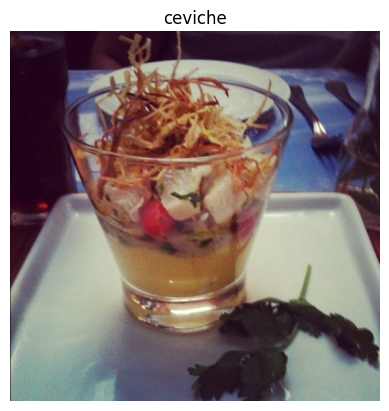

In [25]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()
]) # Add title to image to verify the label is assosciated with the right image
plt.axis(False);

## Create preprocessing functions for our data 📊

In previous notebooks, when our images were in folder format we used the method `tf.keras.utils.image_dataset_from_directory()` to load them in 📁.

Doing this meant our data was loaded into a format ready to be used with our models 📈.

However, since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model 🤔.

More specifically, our data is currently:

* In `uint8` data type 📊
* Comprised of all different sized tensors (different sized images) 📸
* Not scaled (the pixel values are between 0 & 255) 📊

Whereas, models like data to be:

* In `float32` data type 📊
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`) 📈
* Scaled (values between 0 & 1), also called normalized 📊

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using `tf.image.resize()` 📸
* Converts an input image tensor's current datatype to `tf.float32` using `tf.cast()` 📊

> **📽Important:** Pretrained EfficientNetBX models in `tf.keras.applications.efficientnet` (what we're going to be using) have rescaling built-in 🤔. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1) 📊. This could be incorporated inside your "`preprocess_img()`" function (like the one below) or within your model as a `tf.keras.layers.Rescaling` layer 📈.